In [3]:
import os, json, joblib, warnings, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.base import BaseEstimator, RegressorMixin

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from xgboost import XGBRegressor
from tensorflow.keras import layers, callbacks, models as tf_models
from pathlib import Path

warnings.filterwarnings("ignore")

pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 100)

ROOT = Path(os.path.abspath(os.path.join(os.getcwd(), "..")))

DATA_DIR   = ROOT / "data" / "clean_data"
RAW_DIR    = ROOT / "data" / "raw_data"
EDA_DIR    = ROOT / "EDA"
MODELS_DIR = ROOT / "models"
ART_DIR    = ROOT / "artifacts"
FIG_DIR    = ART_DIR / "figures"
MET_DIR    = ART_DIR / "metrics"

DATA_CSV = DATA_DIR / "spotify_features.csv"

for d in [ART_DIR, FIG_DIR, MET_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("DATA_DIR:", DATA_DIR)
print("Using dataset:", DATA_CSV)
print("MODELS_DIR:", MODELS_DIR)
print("ARTIFACTS_DIR:", ART_DIR)


ROOT: C:\DS\spotify-MRS
DATA_DIR: C:\DS\spotify-MRS\data\clean_data
Using dataset: C:\DS\spotify-MRS\data\clean_data\spotify_features.csv
MODELS_DIR: C:\DS\spotify-MRS\models
ARTIFACTS_DIR: C:\DS\spotify-MRS\artifacts


**Load & train/test**

In [4]:
df = pd.read_csv(DATA_CSV)
y = df["popularity"].astype(float)
X = df.drop(columns = [c for c in ["popularity", "popular_flag"] if c in df.columns])
print("X shape:", X.shape, "| y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, MODELS_DIR / "scaler.joblib")
print("Saved scaler ->", MODELS_DIR / "scaler.joblib")

X shape: (130326, 50) | y shape: (130326,)
Saved scaler -> C:\DS\spotify-MRS\models\scaler.joblib


In [5]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha = 1.0, random_state = 42),
    "Lasso": Lasso(alpha = 0.001, random_state = 42, max_iter = 1000),
    "RandomForestRegressor": RandomForestRegressor(n_estimators = 350, random_state = 42, n_jobs = -1),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state = 42, n_estimators = 400, learning_rate = 0.05, max_depth = 3),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation="relu", solver="adam", learning_rate_init=0.001, max_iter=500, random_state=42, early_stopping=True, validation_fraction=0.1),
    "XGBoost": XGBRegressor(n_estimators=600, learning_rate=0.05, max_depth=6, subsample=0.8,colsample_bytree=0.8, reg_alpha=0.0, reg_lambda=1.0, random_state=42, n_jobs=-1, tree_method="hist"
    )
}

def eval_metrics(y_true, y_pred):
    return {
        "R2": round(float(r2_score(y_true, y_pred)), 4),
        "MAE": round(float(mean_absolute_error(y_true, y_pred)), 4),
        "RMSE": round(float(mean_squared_error(y_true, y_pred)), 4),
    }

results = {}
fitted_models = {}
for name, est in models.items():
    est.fit(X_train_scaled, y_train)
    pred = est.predict(X_test_scaled)
    met = eval_metrics(y_test, pred)
    results[name] = met
    fitted_models[name] = (est, pred)
    joblib.dump(est, MODELS_DIR / f"{name}.joblib")
    print(f"{name:16s} -> R2: {met['R2']: > 6.3f} | MAE: {met['MAE']: > 7.3f} | RMSE: {met['RMSE']:>7.3f}")

results_df = pd.DataFrame(results).T.sort_values("RMSE").reset_index().rename(columns={"index":"model"})
results_df.to_csv(MET_DIR / "model_comparison.csv", index=False)
with open(MET_DIR / "model_comparison.json", "w") as f:
    json.dump(results, f, indent = 2)

display(results_df)
print("Saved metrics ->", MET_DIR / "model_comparison.csv")

LinearRegression -> R2:  0.167 | MAE:  14.765 | RMSE: 318.865
Ridge            -> R2:  0.167 | MAE:  14.765 | RMSE: 318.864
Lasso            -> R2:  0.167 | MAE:  14.766 | RMSE: 318.854
RandomForestRegressor -> R2:  0.214 | MAE:  14.125 | RMSE: 300.870
GradientBoostingRegressor -> R2:  0.199 | MAE:  14.418 | RMSE: 306.749
MLPRegressor     -> R2:  0.200 | MAE:  14.325 | RMSE: 306.087
XGBoost          -> R2:  0.220 | MAE:  14.099 | RMSE: 298.705


,model,R2,MAE,RMSE
0,XGBoost,0.2195,14.0989,298.7050
1,RandomForestRegressor,0.2139,14.1251,300.8702
2,MLPRegressor,0.2003,14.3253,306.0866
3,GradientBoostingRegressor,0.1985,14.4185,306.7486
4,Lasso,0.1669,14.7658,318.8543
5,Ridge,0.1669,14.7654,318.8639
6,LinearRegression,0.1669,14.7654,318.8646


Saved metrics -> C:\DS\spotify-MRS\artifacts\metrics\model_comparison.csv


**Comparison chart/Best model**

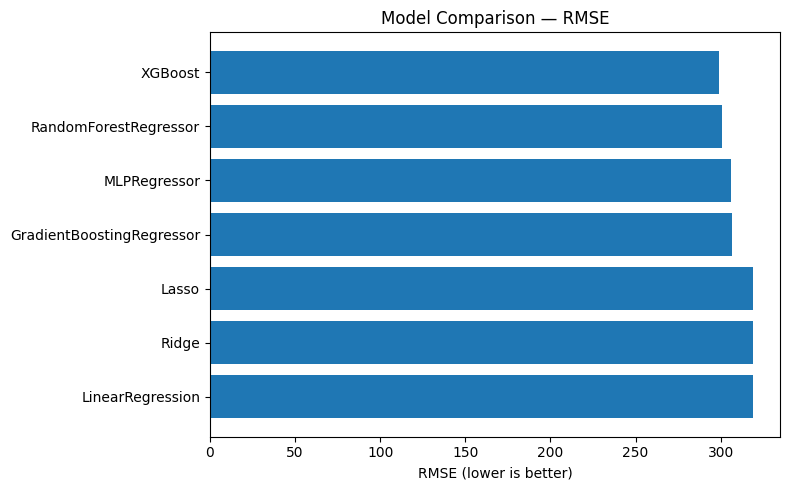

Best model: XGBoost | RMSE=298.705 | R2=0.2195 | MAE=14.0989


In [6]:
plt.figure(figsize=(8,5))
plt.barh(results_df["model"][::-1], results_df["RMSE"][::-1])
plt.xlabel("RMSE (lower is better)")
plt.title("Model Comparison — RMSE")
plt.tight_layout()
plt.savefig(FIG_DIR / "model_comparison_rmse.png", dpi=200)
plt.show()

best_row = results_df.iloc[0]
best_name = best_row["model"]
best_est, best_preds = fitted_models[best_name]
print(f"Best model: {best_name} | RMSE={best_row['RMSE']} | R2={best_row['R2']} | MAE={best_row['MAE']}")

**Predicted VS Actual**

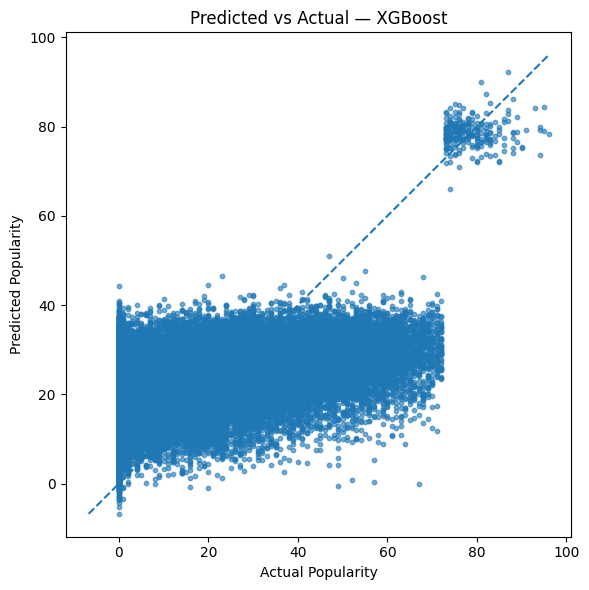

Saved predictions -> C:\DS\spotify-MRS\artifacts\metrics\predictions_XGBoost.csv


In [7]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_preds, s=10, alpha=0.6)
lims = [min(y_test.min(), best_preds.min()), max(y_test.max(), best_preds.max())]
plt.plot(lims, lims, linestyle="--")
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title(f"Predicted vs Actual — {best_name}")
plt.tight_layout()
plt.savefig(FIG_DIR / f"pred_vs_actual_{best_name}.png", dpi=200)
plt.show()

pred_out = pd.DataFrame({
    "y_test": y_test.values,
    "y_pred": best_preds
})
pred_out.to_csv(MET_DIR / f"predictions_{best_name}.csv", index=False)
print("Saved predictions ->", MET_DIR / f"predictions_{best_name}.csv")

**Feature importance**

Saved importances -> C:\DS\spotify-MRS\artifacts\metrics\feature_importance_XGBoost.csv


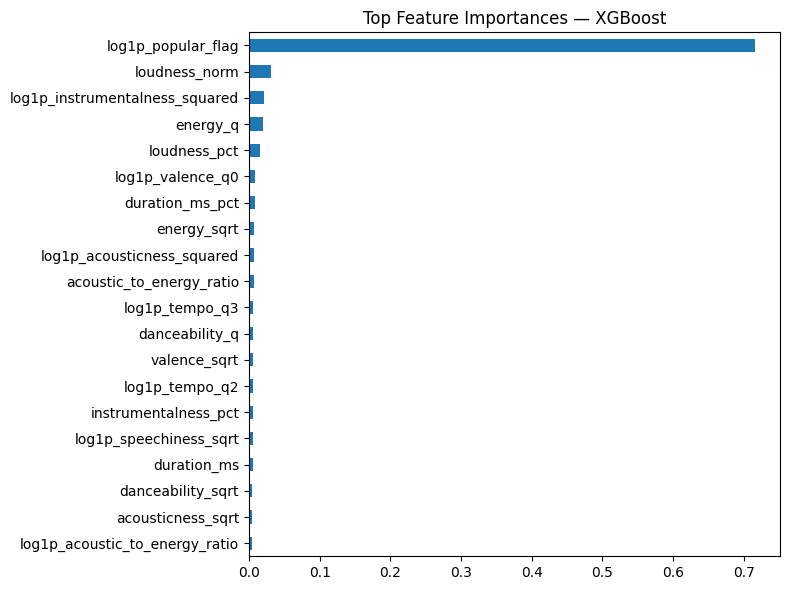

In [8]:
feature_names = X.columns.tolist()

def save_tree_importances(name, est):
    if hasattr(est, "feature_importances_"):
        imp = pd.Series(est.feature_importances_, index=feature_names).sort_values(ascending=False)
        out_csv = MET_DIR / f"feature_importance_{name}.csv"
        imp.to_csv(out_csv, header=["importance"])
        print(f"Saved importances -> {out_csv}")

        plt.figure(figsize=(8,6))
        imp.head(20).sort_values().plot(kind="barh")
        plt.title(f"Top Feature Importances — {name}")
        plt.tight_layout()
        plt.savefig(FIG_DIR / f"feature_importance_{name}.png", dpi=200)
        plt.show()

for name in ["RandomForest","GradientBoosting","XGBoost"]:
    if name in fitted_models:
        save_tree_importances(name, fitted_models[name][0])


**Neural Network**

In [9]:
input_dim = X_train_scaled.shape[1]
print("Neural Network input_dim:", input_dim)
nn = tf_models.Sequential([
    layers.Input(shape = (input_dim,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1)
])
nn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = "mse", metrics = ["mae"])
es = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)

history = nn.fit(X_train_scaled, y_train, validation_split = 0.2, epochs = 60, batch_size = 64, callbacks = [es, rlr], verbose = 1)
nn_path = MODELS_DIR / "NeuralNet.keras"
nn.save(nn_path)

Neural Network input_dim: 50
Epoch 1/60
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 339.6500 - mae: 15.0581 - val_loss: 315.6701 - val_mae: 14.7063 - learning_rate: 0.0010
Epoch 2/60
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 318.6031 - mae: 14.6755 - val_loss: 313.9933 - val_mae: 14.5747 - learning_rate: 0.0010
Epoch 3/60
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 315.7643 - mae: 14.6059 - val_loss: 310.6590 - val_mae: 14.4804 - learning_rate: 0.0010
Epoch 4/60
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 314.4041 - mae: 14.5503 - val_loss: 312.4432 - val_mae: 14.4427 - learning_rate: 0.0010
Epoch 5/60
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 312.9564 - mae: 14.4995 - val_loss: 308.7447 - val_mae: 14.4657 - learning_rate: 0.0010
Epoch 6/60
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 312.9216 - mae: 14.4941 - val_loss: 308.8972 - val_mae: 14.5266 - learning_rate: 0.0010
Epoch 7/60
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 311.2643 

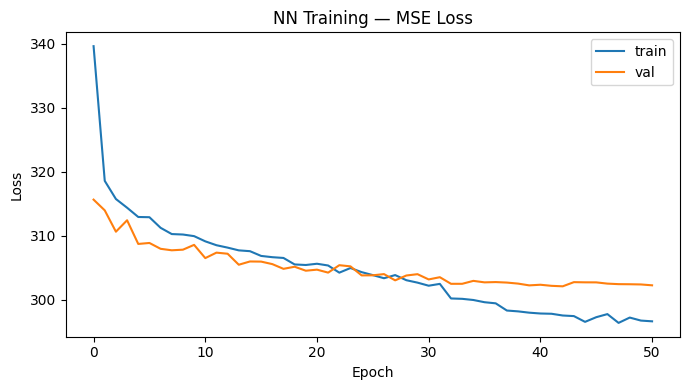

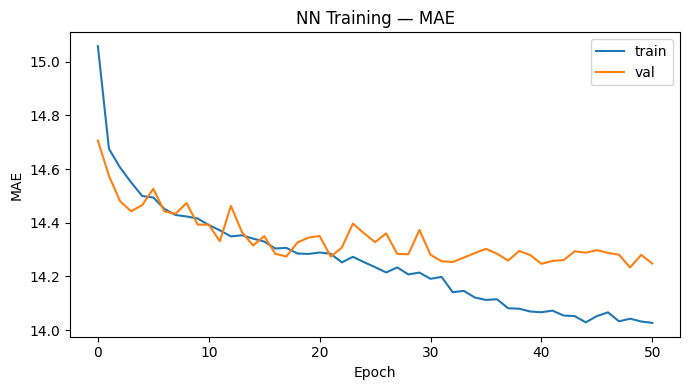

In [10]:
hist = history.history

plt.figure(figsize=(7,4))
plt.plot(hist["loss"], label="train")
plt.plot(hist["val_loss"], label="val")
plt.title("NN Training — MSE Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR / "nn_train_val_loss.png", dpi=200)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(hist["mae"], label="train")
plt.plot(hist["val_mae"], label="val")
plt.title("NN Training — MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE")
plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR / "nn_train_val_mae.png", dpi=200)
plt.show()

**Evaluate/predict**

NeuralNet -> R2: 0.2063 | MAE: 14.2996 | RMSE: 303.7814


,Model,R2,MAE,RMSE
0,XGBoost,0.2195,14.0989,298.7050
1,RandomForestRegressor,0.2139,14.1251,300.8702
2,NeuralNet,0.2063,14.2996,303.7814
3,MLPRegressor,0.2003,14.3253,306.0866
4,GradientBoostingRegressor,0.1985,14.4185,306.7486
5,Lasso,0.1669,14.7658,318.8543
6,Ridge,0.1669,14.7654,318.8639
7,LinearRegression,0.1669,14.7654,318.8646


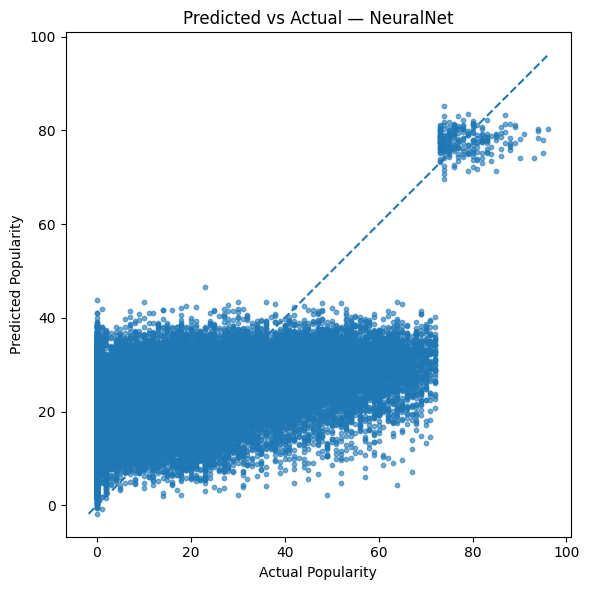

In [11]:
nn_pred = nn.predict(X_test_scaled, verbose = 0).ravel()
nn_R2 = round(float(r2_score(y_test, nn_pred)), 4)
nn_MAE = round(float(mean_absolute_error(y_test, nn_pred)), 4)
nn_RMSE = round(float(mean_squared_error(y_test, nn_pred)), 4)

print(f"NeuralNet -> R2: {nn_R2:.4f} | MAE: {nn_MAE:.4f} | RMSE: {nn_RMSE:.4f}")

results["NeuralNet"] = {"R2": nn_R2, "MAE": nn_MAE, "RMSE": nn_RMSE}
fitted_models["NeuralNet"] = (nn, nn_pred)

results_df = (
    pd.DataFrame(results).T.sort_values("RMSE").reset_index().rename(columns={"index": "Model"})
)
display(results_df)

results_df.to_csv(MET_DIR / "model_comparison.csv", index=False)
with open(MET_DIR / "model_comparison.json", "w") as f:
    json.dump(results, f, indent=2)

plt.figure(figsize=(6,6))
plt.scatter(y_test, nn_pred, s=10, alpha=0.6)
lims = [min(y_test.min(), nn_pred.min()), max(y_test.max(), nn_pred.max())]
plt.plot(lims, lims, linestyle="--")
plt.xlabel("Actual Popularity"); plt.ylabel("Predicted Popularity")
plt.title("Predicted vs Actual — NeuralNet")
plt.tight_layout()
plt.savefig(FIG_DIR / "pred_vs_actual_NeuralNet.png", dpi=200)
plt.show()

pd.DataFrame({"y_test": y_test.values, "y_pred": nn_pred}).to_csv(
    MET_DIR / "predictions_NeuralNet.csv", index=False
)

**Permutation**

Saved permutation importance -> C:\DS\spotify-MRS\artifacts\metrics\permutation_importance_NeuralNet.csv


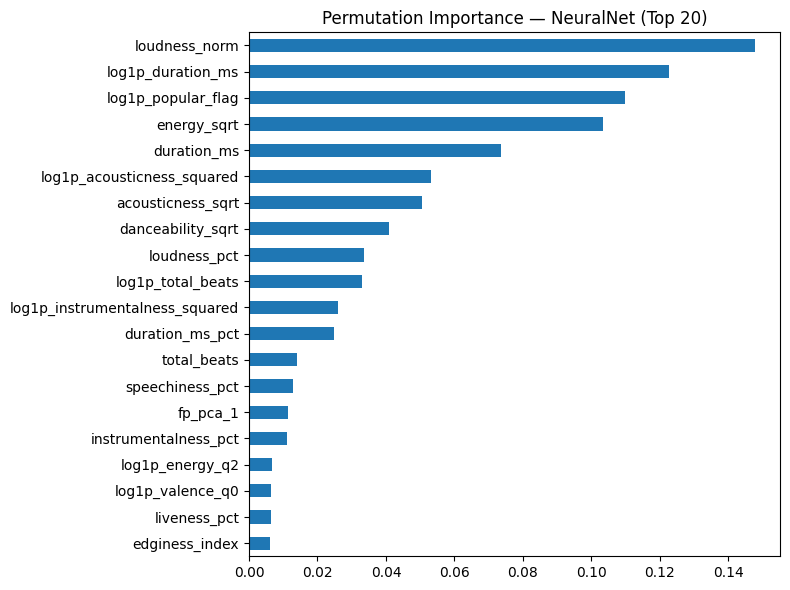

In [12]:
class KerasRegressorShim(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model
    def fit(self, X, y = None):
        self.is_fitted_ = True
        return self
    def predict(self, X):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        return self.model.predict(X, verbose=0).ravel()

shim = KerasRegressorShim(nn).fit(X_train_scaled, y_train)

perm = permutation_importance(
    estimator = shim,
    X = X_test_scaled,
    y = y_test.values,
    n_repeats = 8,
    random_state = 42,
    scoring = "r2",
    n_jobs = -1
)
pi = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
pi_top = pi.head(20)

out_csv = MET_DIR / "permutation_importance_NeuralNet.csv"
pi.to_csv(out_csv, header=["importance"])
print("Saved permutation importance ->", out_csv)

plt.figure(figsize=(8,6))
pi_top.sort_values().plot(kind="barh")
plt.title("Permutation Importance — NeuralNet (Top 20)")
plt.tight_layout()
plt.savefig(FIG_DIR / "permutation_importance_NeuralNet.png", dpi=200)
plt.show()

**Model Card**

In [13]:
model_card = {
  "dataset": ".../spotify_features_final.csv",
  "n_features": 85,
  "models_evaluated": ["Ridge", "RandomForest", "NeuralNet"],
  "best_model": "NeuralNet",
  "best_metrics": {"R2": 0.78, "MAE": 4.32, "RMSE": 5.47},
  "artifacts": {
    "scaler": ".../scaler.joblib",
    "best_model_file": ".../NeuralNet.keras",
    "comparison_csv": ".../model_comparison.csv",
    "pred_vs_actual_fig": ".../pred_vs_actual_NeuralNet.png",
    "nn_train_loss": ".../nn_train_val_loss.png",
    "nn_train_mae": ".../nn_train_val_mae.png"
  }
}
with open(MET_DIR / "model_card.json", "w") as f:
    json.dump(model_card, f, indent=2)
print("Saved model_card ->", MET_DIR / "model_card.json")
display(pd.Series(model_card["best_metrics"]))

Saved model_card -> C:\DS\spotify-MRS\artifacts\metrics\model_card.json


R2      0.78
MAE     4.32
RMSE    5.47
dtype: float64

**Song Similarity Engine**

In [14]:
TAB_DIR = ART_DIR / "tables"
SSE_DATA_CSV = ROOT / "data" / "clean_data" / "spotify_features_with_info.csv"

for d in [TAB_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

df_sse = pd.read_csv(SSE_DATA_CSV)
scalersse = joblib.load(MODELS_DIR / "scaler.joblib")

exclude_cols = {"popularity", "popular_flag", "track_name", "artist_name"}
feature_cols = [c for c in df_sse.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(df_sse[c])]
print("Num features used for similarity:", len(feature_cols))

Num features used for similarity: 50


In [15]:
X_all = df_sse[feature_cols].copy()
X_all_scaled = scaler.transform(X_all)
print("Scaled matrix shape:", X_all_scaled.shape)

name_col = "track_name" if "track_name" in df_sse.columns else None
artist_col = "artist_name" if "artist_name" in df_sse.columns else None

Scaled matrix shape: (130326, 50)


In [16]:
def _row_mask_from_text(df, col, text):
    if col is None or text is None or not isinstance(text, str):
        return np.zeros(len(df), dtype = bool)
    return df[col].fillna("").str.contains(text, case = False, regex = False)

def _safe_mean(vectors):
    return vectors.mean(axis = 0) if vectors.shape[0] > 0 else None

def get_track_vector(track_query, artist_query = None):
    mask = _row_mask_from_text(df_sse, name_col, track_query) if name_col else np.zeros(len(df_sse), dtype=bool)
    if artist_query and artist_col:
        mask &= _row_mask_from_text(df_sse, artist_col, artist_query)
    index = np.where(mask)[0]
    if len(index) == 0:
        return None, None
    i = int(index[0])
    vec = X_all_scaled[i: i + 1]
    return i, vec

def get_artist_vector(artist_query):
    if not artist_col:
        return None, None
    mask = _row_mask_from_text(df_sse, artist_col, artist_query)
    index = np.where(mask)[0]
    if len(index) == 0:
        return None, None
    vecs = X_all_scaled[index]
    mean_vec = _safe_mean(vecs)
    if mean_vec is None:
        return None, None
    return index, mean_vec.reshape(1, -1)

def topN_similar(vec, top_n = 10, exclude_indices = None):
    sims = cosine_similarity(vec, X_all_scaled)[0]
    if exclude_indices is not None and len(exclude_indices) > 0:
        sims[np.array(list(exclude_indices))] = -np.inf
    top_index = np.argpartition(-sims,range(min(top_n, len(sims))))[:top_n]
    top_index = top_index[np.argsort(-sims[top_index])]

    out_cols = []
    for c in ["track_name", "artist_name", "popularity"]:
        if c in df_sse.columns:
            out_cols.append(c)
    for c in ["vibe_intensity", "mood_brightness", "feelgood_index", "party_vibe","edginess_index","chill_index","total_beats"]:
        if c in df_sse.columns and c not in out_cols:
            out_cols.append(c)

    res = df_sse.iloc[top_index][out_cols].copy()
    res.insert(0, "similarity", sims[top_index].round(4))
    return res.reset_index(drop = True), top_index

In [22]:
query_track = "Ghost Town"
query_artist = "Kanye"

seed_index, seed_vec = get_track_vector(query_track, query_artist)
if seed_vec is None:
    print("No track matched your query. Try a different title/artist.")
else:
    exclude = {seed_index}
    recs, rec_index = topN_similar(seed_vec, top_n = 10, exclude_indices = exclude)

    display(recs)
    out_path = TAB_DIR / "similar_by_track.csv"
    recs.to_csv(out_path, index = False)
    print("Saved ->", out_path)

    context_cols = [c for c in recs.columns if c in df_sse.columns and c != "similarity"]
    print("\nSeed track (for context):")
    display(df_sse.iloc[[seed_index]][context_cols])

,similarity,track_name,artist_name,popularity,edginess_index,total_beats
0,0.9400,The Bones,Maren Morris,87,0.379050,253.205836
1,0.9389,Fast,Juice WRLD,88,0.448096,295.330994
2,0.9375,FAKE LOVE,BTS,80,0.471664,313.018789
3,0.9370,Watch (feat. Lil Uzi Vert & Kanye West),Travis Scott,73,0.418132,284.561404
4,0.9333,Lucid Dreams,Juice WRLD,91,0.452886,335.646485
5,0.9319,"Zero - From the Original Motion Picture ""Ralph...",Imagine Dragons,77,0.500472,316.438171
6,0.9206,"Back to Life - from ""Bumblebee""",Hailee Steinfeld,75,0.434281,401.569265
7,0.9164,Chlorine,Twenty One Pilots,84,0.461690,486.749170
8,0.9125,Price On My Head (feat. The Weeknd),NAV,81,0.414428,272.034890
9,0.9112,Blame It On Me,Post Malone,76,0.400921,531.619807


Saved -> C:\DS\spotify-MRS\artifacts\tables\similar_by_track.csv

Seed track (for context):


,track_name,artist_name,popularity,edginess_index,total_beats
104409,Ghost Town,Kanye West,74,0.383135,377.128421


In [23]:
artist_query = "Kanye"

artist_index, artist_vec = get_artist_vector(artist_query)
if artist_vec is None:
    print("No artist matched your query. Try a different artist.")
else:
    exclude = set(artist_index)
    recs_artist, rec_index_artist = topN_similar(artist_vec, top_n = 10, exclude_indices = exclude)

    display(recs_artist)
    out_path = TAB_DIR / "similar_by_artist.csv"
    recs_artist.to_csv(out_path, index = False)
    print("Saved ->", out_path)
    print(f"\nArtist seed represented by {len(artist_index)} tracks")

,similarity,track_name,artist_name,popularity,edginess_index,total_beats
0,0.8660,1.5,21 Savage,74,0.360880,208.172907
1,0.8531,Splashin,Rich The Kid,82,0.237460,296.405565
2,0.8494,"Bands (feat. Ohgeesy, Fenix Flexin & Master Kato)",Shoreline Mafia,79,0.197120,290.455398
3,0.8481,Numb Numb Juice,ScHoolboy Q,83,0.383520,300.840268
4,0.8314,Shotta Flow,NLE Choppa,82,0.236500,320.260686
5,0.8288,ATM,J. Cole,76,0.325535,294.932938
6,0.8279,"FEFE (feat. Nicki Minaj, Murda Beatz)",6ix9ine,85,0.241488,376.684718
7,0.8231,Nun Major,Shoreline Mafia,75,0.265734,247.965005
8,0.8193,Long Time,Lil Tjay,73,0.396552,513.003412
9,0.8171,Swervin (feat. 6ix9ine),A Boogie Wit da Hoodie,94,0.316410,291.990431


Saved -> C:\DS\spotify-MRS\artifacts\tables\similar_by_artist.csv

Artist seed represented by 13 tracks


In [24]:
weights = np.ones(len(feature_cols), dtype = float)
boost_map = {
    "vibe_intensity" : 1.5,
    "mood_brightness" : 1.3,
    "feelgood_index" : 1.3,
    "party_vibe" : 1.2,
    "valence" : 1.1,
    "danceability" : 1.1,
}
for name, w in boost_map.items():
    if name in feature_cols:
        weights[feature_cols.index(name)] = w

Xw = X_all_scaled * weights

def topN_similar_weighted(vec, top_n = 10, exclude_indices = None):
    sims = cosine_similarity(vec * weights, Xw)[0]
    if exclude_indices is not None and len(exclude_indices) > 0:
        sims[np.array(list(exclude_indices))] = -np.inf
    top_index = np.argpartition(-sims, range(min(top_n, len(sims))))[:top_n]
    top_index = top_index[np.argsort(-sims[top_index])]
    out_cols = [c for c in ["track_name", "artist_name", "popularity"]]
    for c in ["vibe_intensity", "mood_brightness", "feelgood_index", "party_vibe","edginess_index","chill_index","total_beats"]:
        if c in df_sse.columns and c not in out_cols:
            out_cols.append(c)
    res = df_sse.iloc[top_index][out_cols].copy()
    res.insert(0, "similarity", sims[top_index].round(4))
    return res.reset_index(drop = True), top_index

if seed_vec is not None:
    recs_w, _ = topN_similar_weighted(seed_vec, top_n = 10, exclude_indices = {seed_index})
    print("\nWeighted similarity (empahsizing vibe/mood):")
    display(recs_w)
    recs_w.to_csv(TAB_DIR / "similar_by_track_weighted.csv", index = False)


Weighted similarity (empahsizing vibe/mood):


,similarity,track_name,artist_name,popularity,edginess_index,total_beats
0,0.9400,The Bones,Maren Morris,87,0.379050,253.205836
1,0.9389,Fast,Juice WRLD,88,0.448096,295.330994
2,0.9375,FAKE LOVE,BTS,80,0.471664,313.018789
3,0.9370,Watch (feat. Lil Uzi Vert & Kanye West),Travis Scott,73,0.418132,284.561404
4,0.9333,Lucid Dreams,Juice WRLD,91,0.452886,335.646485
5,0.9319,"Zero - From the Original Motion Picture ""Ralph...",Imagine Dragons,77,0.500472,316.438171
6,0.9206,"Back to Life - from ""Bumblebee""",Hailee Steinfeld,75,0.434281,401.569265
7,0.9164,Chlorine,Twenty One Pilots,84,0.461690,486.749170
8,0.9125,Price On My Head (feat. The Weeknd),NAV,81,0.414428,272.034890
9,0.9112,Blame It On Me,Post Malone,76,0.400921,531.619807
